Считаем что задаем прямые парметрическим уравнением
В трёхмерном пространстве прямая может быть задана в параметрической форме следующим образом:

$$
v = P + td 
$$

где:
- **P** = (x₀, y₀, z₀) – точка, через которую проходит прямая;
- **d** = (n, m, p) – направляющий вектор прямой;
- **t** – параметр, принимающий любые значения из $\mathbb{R}$.
- **v** – координаты точки на прямой из $\mathbb{R}^3$.

Таким образом, координаты точки на прямой можно записать как:
$$
\begin{cases}
x = x_0 + t n, \\
y = y_0 + t m, \\
z = z_0 + t p, \\
\end{cases}
$$

Найти пересечение прямых можно решив систему вида 
$$
\begin{cases} 
x_{01} + t n_{1} = x_{02} + s n_{2} \\ 
y_{01} + t m_{1} = y_{02} + s m_{2} \\ 
z_{01} + t p_{1} = z_{02} + s p_{2} 
\end{cases}
$$

In [1]:
from matplotlib import lines
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

H_out = 32 # считаем осью OY
W_out = 32 # считаем осью OX


In [2]:
class Line:
    def __init__(self, x0, y0, z0, m, n, p):
        self.offset = np.array([x0, y0, z0], dtype=float)
        self.multiply = np.array([m, n, p], dtype=float)

    def get_dot(self, t):
        return self.offset + t * self.multiply

    def intersection(self, other):
        A = np.array([self.multiply, -other.multiply, np.cross(self.multiply, other.multiply)]).T
        B = np.array(other.offset) - np.array(self.offset)
        try:
            t, s, _ = np.linalg.solve(A, B)
        except np.linalg.LinAlgError:
            return None
        
        return self.get_dot(t)
    
def make_lines_two_points(point_1, point_2):
    return Line(*point_1, *(point_2 - point_1))

In [3]:
# Пример 

l1 = Line(0, 0, 0, 1, 1, 1)

l2 = Line(2, 2, 1, 1, 0, 0)

l1.intersection(l2)

print(l1.intersection(l2))

[1.5 1.5 1.5]


Уравнение плоскости задается как:
$$ 
Ax + By + Cz + D = 0 
$$

Параметрическое уравнение прямой:
$$ 
\mathbf{r}(t) = \mathbf{p} + t\mathbf{d} 
$$
где $\mathbf{p} = (x_0, y_0, z_0)$ — точка на прямой, $\mathbf{d} = (d_x, d_y, d_z)$ — направляющий вектор прямой.

Подставляя параметры прямой в уравнение плоскости:
$$ 
A(x_0 + td_x) + B(y_0 + td_y) + C(z_0 + td_z) + D = 0 
$$

Распределяем и группируем члены:
$$ 
A x_0 + A t d_x + B y_0 + B t d_y + C z_0 + C t d_z + D = 0 
$$

$$ 
A t d_x + B t d_y + C t d_z = - (A x_0 + B y_0 + C z_0 + D)
$$

$$ 
t (A d_x + B d_y + C d_z) = - (A x_0 + B y_0 + C z_0 + D)
$$

Итак, находим $t$:
$$
t = -\frac{A x_0 + B y_0 + C z_0 + D}{A d_x + B d_y + C d_z} = -\frac{\mathbf{n}\mathbf{p} + D}{\mathbf{n}\mathbf{d}}
$$

In [4]:
class Plane:
    def __init__(self, A, B, C, D):
        self.normal_vector = np.array([A, B, C])
        self.free = D

    def intersection_with_line(self, line):
        t = -(np.dot(self.normal_vector, line.offset) + self.free) / np.dot(self.normal_vector, line.multiply)
        return line.get_dot(t)

In [5]:
# Пример 

l1 = Line(0, 0, 0, 1, 1, 1)

l2 = Line(2, 2, 1, 1, 0, 0)

l1.intersection(l2)

print(l1.intersection(l2))

plane = Plane(1, 0, 0, -10)

print(plane.intersection_with_line(l1))

[1.5 1.5 1.5]
[10. 10. 10.]


In [6]:
def thin_lens_image_input_lines(
    input_image: np.ndarray,
    f: float,
    a: float,
):
    H_in, W_in = input_image.shape[:2]
    error = [0]
    try:
        b = (a * f) / (a - f)
    except ZeroDivisionError:
        b = 1e9 # типо бесконечность 
    

    M = b / - a   # Увеличение изображение
                # Если M > 0 то     перевернутое    действительное
                # Если M < 0 то     прямое          мнимое

    
    output_image = np.zeros((H_out, W_out, 3), dtype=np.uint8)


    # отдельно считаем для центра картинки 
    color = input_image[H_in // 2, W_in // 2]
    val = (color).astype(np.uint8)
    output_image[int(np.round(H_out / 2)), int(np.round(W_out / 2))] = val

    for i_in in range(H_in):
        for j_in in range(W_in):
            y_in = i_in - H_in / 2
            x_in = j_in - W_in / 2
            # рассмотрим ход лучей в плоскости 
            #                           точка на картине
            #                           главная оптическа ось 

            # луч 1 проходит через точку и центр линзы и не преломляется
            # луч 2 проходит параллельно оптической оси линзы
            #   и преломлятся в фокус

            l1 = make_lines_two_points(np.array([0, 0, 0]), np.array([x_in, y_in, -a]))
            l2 = make_lines_two_points(np.array([0, 0, f]), np.array([x_in, y_in, 0]))

            out_point = l1.intersection(l2)
            if out_point is None:
                # print("Паралельные лучи из точки: ", i_in, j_in)
                continue
            error.append(out_point[2] - b)
            
            i_out, j_out = int(np.round(out_point[1] + H_out / 2)),  int(np.round(out_point[0] + W_out / 2))

            if 0 <= i_out < H_out and 0 <= j_out < W_out:
                color = input_image[i_in, j_in]

                val = (color).astype(np.uint8)
                output_image[i_out, j_out] = val
    
    return output_image, b, M, sum(error)/len(error)


def thin_lens_image_output_lines(
    input_image: np.ndarray,
    f: float,
    a: float
):
    H_in, W_in = input_image.shape[:2]
    error = [0]
    try:
        b = (a * f) / (a - f)
    except ZeroDivisionError:
        b = 50 # типо бесконечность 
    

    M = b / - a   # Увеличение изображение
                # Если M > 0 то     перевернутое    действительное
                # Если M < 0 то     прямое          мнимое
    
    
    output_image = np.zeros((H_out, W_out, 3), dtype=np.uint8)

    # отдельно считаем для центра картинки 
    color = input_image[H_in // 2, W_in // 2]
    val = (color).astype(np.uint8)
    output_image[int(np.round(H_out / 2)), int(np.round(W_out / 2))] = val

    for i_out in range(H_out):
        for j_out in range(W_out):
            y_out = i_out - H_out / 2
            x_out = j_out - W_out / 2
            # рассмотрим ход лучей в плоскости 
            #                           точка на картине
            #                           главная оптическа ось 

            # луч 1 проходит через точку и центр линзы и не преломляется
            # луч 2 проходит параллельно оптической оси линзы
            #   и преломлятся в фокус

            l1 = make_lines_two_points(np.array([0, 0, 0]), np.array([x_out, y_out, b]))
            l2 = make_lines_two_points(np.array([0, 0, -f]), np.array([x_out, y_out, 0]))
            inp_img_plane = Plane(0, 0, 1, a) # точки на плоскости картины

            in_point_1 = inp_img_plane.intersection_with_line(l1)
            in_point_2 = inp_img_plane.intersection_with_line(l2)
            error.append(in_point_1 - in_point_2)
            in_point = (in_point_1 + in_point_2) / 2
            if in_point is None:
                # print("Паралельные лучи из точки: ", i_out, j_out)
                continue
            # error.append(in_point[2] - a)
            
            i_in, j_in = int(np.round(in_point[1] + H_in / 2)),  int(np.round(in_point[0] + W_in / 2))

            if 0 <= i_in < H_in and 0 <= j_in < W_in:
                color = input_image[i_in, j_in]

                val = (color).astype(np.uint8)
                output_image[i_out, j_out] = val
    
    return output_image, b, M, sum(error)/len(error)


Пропускаем нашу картинку через обычную тонкую линзу

Мнимое изображение, b=-2.667 < 0
Увеличение M=1.333
Ошибка в расчете координаты итоговой картинки 1 = 7.632783294297951e-17
Ошибка в расчете координаты итоговой картинки 2 = 0.0


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

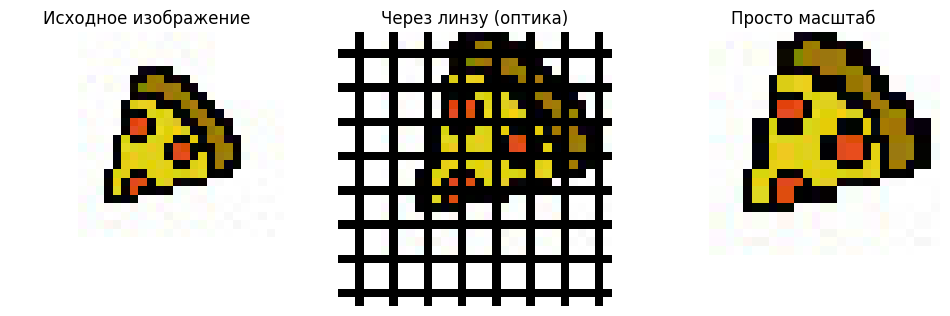

In [7]:
img_in = Image.open("/Users/lida-os/mipt/physic/Physics-2025/M3_task/pixel_art.jpg")
img_in_np = np.array(img_in) 
    
# Параметры тонкой линзы
f_lens = 8   
a_obj = 2
    
    # Запуск преобразования
out, b_dist, M_factor, error = thin_lens_image_input_lines(
    img_in_np, f_lens, a_obj
)

another_out, _, _, error_2 = thin_lens_image_output_lines(
    img_in_np, f_lens, a_obj
)

if b_dist > 0:
    print(f"Действительное изображение, b={b_dist:.3f} > 0")
else:
    print(f'Мнимое изображение, b={b_dist:.3f} < 0')
print(f"Увеличение M={M_factor:.3f}")
print(f'Ошибка в расчете координаты итоговой картинки 1 = {error}')
print(f'Ошибка в расчете координаты итоговой картинки 2 = {np.sqrt(sum(i*i for i in list(error_2))) / len(error_2)}')

img_out = Image.fromarray(out)
img_out.save("/Users/lida-os/mipt/physic/Physics-2025/M3_task/output_lens.jpg")

img_out_another = Image.fromarray(another_out)
img_out_another.save("/Users/lida-os/mipt/physic/Physics-2025/M3_task/output_lens_another.jpg")

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(img_in_np)
axs[0].set_title("Исходное изображение")
axs[0].axis("off")

axs[1].imshow(out)
axs[1].set_title("Через линзу (оптика)")
axs[1].axis("off")

axs[2].imshow(np.array(another_out))
axs[2].set_title("Просто масштаб")
axs[2].axis("off")


Делаем микроскоп

Действительное изображение, b=6.000 > 0
Действительное изображение, b=50.000 > 0
Увеличение M1=-2.000, M2=-12.500
Ошибка в расчете координаты итоговой картинки 1 = [0.03999984 0.03999984 0.        ]


(np.float64(-0.5), np.float64(499.5), np.float64(499.5), np.float64(-0.5))

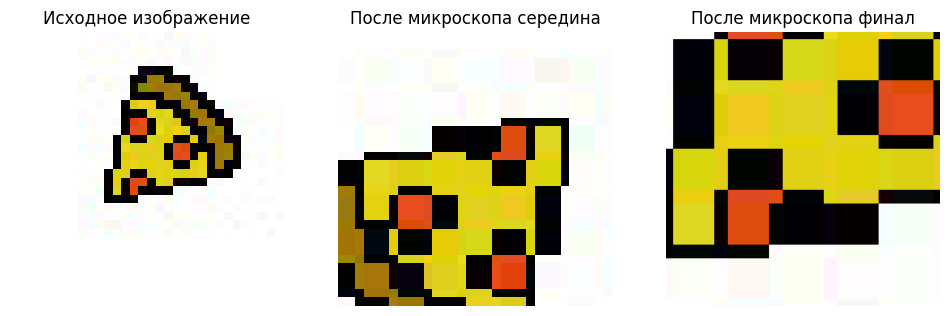

In [8]:
f1, f2 = 2, 4
L = 10
a = 3

# H_out = 32 # считаем осью OY
# W_out = 32 # считаем осью OX

mic_out_1, b_1, M_mic_1, error_mic = thin_lens_image_output_lines(
    img_in_np, f1, a
)

if b_1 > 0:
    print(f"Действительное изображение, b={b_1:.3f} > 0")
else:
    print(f'Мнимое изображение, b={b_1:.3f} < 0')


H_out = 500 # считаем осью OY
W_out = 500 # считаем осью OX

mic_out_2, b_2, M_mic_2, error_mic = thin_lens_image_output_lines(
    mic_out_1, f2, L-b_1
)
if b_2 > 0:
    print(f"Действительное изображение, b={b_2:.3f} > 0")
else:
    print(f'Мнимое изображение, b={b_2:.3f} < 0')
print(f"Увеличение M1={M_mic_1:.3f}, M2={M_mic_2:.3f}")
print(f'Ошибка в расчете координаты итоговой картинки 1 = {error_mic}')

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(img_in_np)
axs[0].set_title("Исходное изображение")
axs[0].axis("off")

axs[1].imshow(mic_out_1)
axs[1].set_title("После микроскопа середина")
axs[1].axis("off")

axs[2].imshow(mic_out_2)
axs[2].set_title("После микроскопа финал")
axs[2].axis("off")

Делаем телескоп

Действительное изображение, b=2.083 > 0
Мнимое изображение, b=-188.000 < 0
Увеличение M1=-0.042, M2=48.000
Ошибка в расчете координаты итоговой картинки 1 = [0. 0. 0.]


(np.float64(-0.5), np.float64(499.5), np.float64(499.5), np.float64(-0.5))

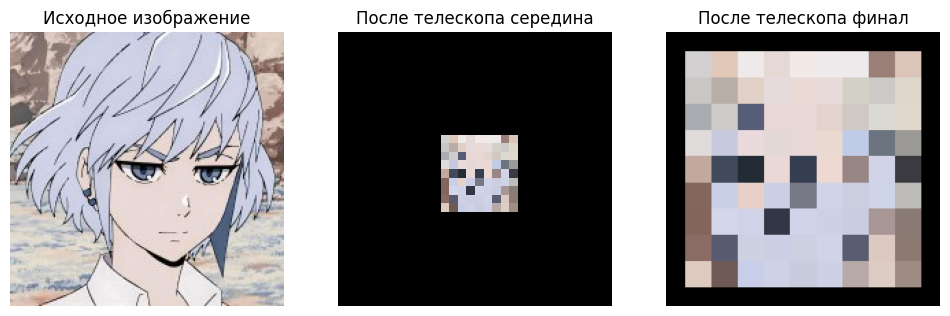

In [9]:
img_in_np = Image.open("/Users/lida-os/mipt/physic/Physics-2025/M3_task/big_picture.jpg")
big_img_in_np = np.array(img_in_np) 

f1, f2 = 2, 4
L = 6
a = 50
H_out = 32 # считаем осью OY
W_out = 32 # считаем осью OX

tel_out_1, b_1, M_tel_1, error_tel = thin_lens_image_output_lines(
    big_img_in_np, f1, a
)

if b_1 > 0:
    print(f"Действительное изображение, b={b_1:.3f} > 0")
else:
    print(f'Мнимое изображение, b={b_1:.3f} < 0')


H_out = 500 
W_out = 500 

tel_out_2, b_2, M_tel_2, error_tel = thin_lens_image_output_lines(
    tel_out_1, f2, L-b_1
)
if b_2 > 0:
    print(f"Действительное изображение, b={b_2:.3f} > 0")
else:
    print(f'Мнимое изображение, b={b_2:.3f} < 0')
print(f"Увеличение M1={M_tel_1:.3f}, M2={M_tel_2:.3f}")
print(f'Ошибка в расчете координаты итоговой картинки 1 = {error_tel}')



fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(img_in_np)
axs[0].set_title("Исходное изображение")
axs[0].axis("off")

axs[1].imshow(tel_out_1)
axs[1].set_title("После телескопа середина")
axs[1].axis("off")

axs[2].imshow(tel_out_2)
axs[2].set_title("После телескопа финал")
axs[2].axis("off")